In [ ]:
### https://www.kaggle.com/code/trngtrngquc/resnet50-tuning

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from tqdm import tqdm_notebook as tqdm
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import matplotlib.pyplot as plt
import cv2 # pip install opencv-python
import torch
# Neural networks can be constructed using the torch.nn package.
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset
import torchvision
import torchvision.transforms as transforms

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
!nvidia-smi

Thu May  5 11:00:57 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P8    28W / 149W |      3MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: ignored

In [ ]:
BASE_PATH = '/content/drive/MyDrive/Жуки/archive/ArTaxOr'
foldername = [ 'Araneae','Coleoptera','Diptera','Hemiptera','Hymenoptera','Lepidoptera','Odonata']

In [ ]:
images=[]
labels=[]

for item in foldername:
    dir = os.path.join(BASE_PATH, item)
    for file in os.listdir(dir):
        if file != "annotations":
            images.append(file)
            labels.append(item)
            
data = {'Images':images, 'labels':labels} 
data = pd.DataFrame(data) 
data.info()

FileNotFoundError: ignored

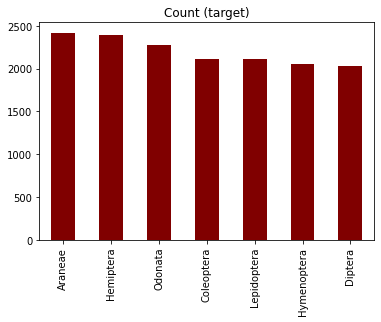

In [ ]:


df_train = data
#print(df_train.labels)
#title = foldername
target_count = df_train.labels.value_counts()
target_count.plot(kind='bar',color ='maroon', title='Count (target)');

In [ ]:
lb = LabelEncoder()
data['encoded_labels'] = lb.fit_transform(data['labels'])
data.head()

,Images,labels,encoded_labels
0,9b38888c018e.jpg,Araneae,0
1,9618aacd6008.jpg,Araneae,0
2,96773aa08125.jpg,Araneae,0
3,99c3c3b75116.jpg,Araneae,0
4,99db1c36a136.jpg,Araneae,0


In [ ]:
batch_size = 14
validation_split = 0.25
test_split = 0.2
shuffle_dataset = True
random_seed= 42
input_size = 224

dataset_size = len(data)
indices = list(range(dataset_size))
split_test = int(np.floor(test_split * dataset_size))

if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)

train_indices, test_indices = indices[split_test:], indices[:split_test]

train_size = len(train_indices)
split_val = int(np.floor(validation_split * train_size))
train_indices, val_indices = train_indices[split_val:], train_indices[:split_val]

dataset_sizes = {'train':len(train_indices), 'val': len(val_indices),'test': len(test_indices)}
dataset_sizes

{'test': 3075, 'train': 9226, 'val': 3075}

In [ ]:
# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)

In [ ]:
transform = transforms.Compose([
                transforms.RandomResizedCrop(input_size),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])

In [ ]:
class Arthopod_Dataset(Dataset):
    def __init__(self, img_data,img_path,transform=None):
        self.img_path = img_path
        self.transform = transform
        self.img_data = img_data
        
    def __len__(self):
        return len(self.img_data)
    
    def __getitem__(self, index):
        img_name = os.path.join(self.img_path,
                                self.img_data.loc[index, 'labels'],
                                self.img_data.loc[index, 'Images'])
        image = Image.open(img_name)
        #image = image.convert('RGB')
        image = image.resize((224,224))
        label = torch.tensor(self.img_data.loc[index, 'encoded_labels'])
        if self.transform is not None:
            image = self.transform(image)
        return image, label
    
transform = transforms.Compose([
                transforms.RandomResizedCrop(input_size),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])

In [ ]:
dataset = Arthopod_Dataset(data,BASE_PATH,transform)

In [ ]:
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                sampler=test_sampler)

In [ ]:
dataloaders_dict ={'train':train_loader , "val":validation_loader, "test":test_loader }
dataloaders_dict

{'test': <torch.utils.data.dataloader.DataLoader at 0x7fa378794310>,
 'train': <torch.utils.data.dataloader.DataLoader at 0x7fa378794c10>,
 'val': <torch.utils.data.dataloader.DataLoader at 0x7fa378788810>}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


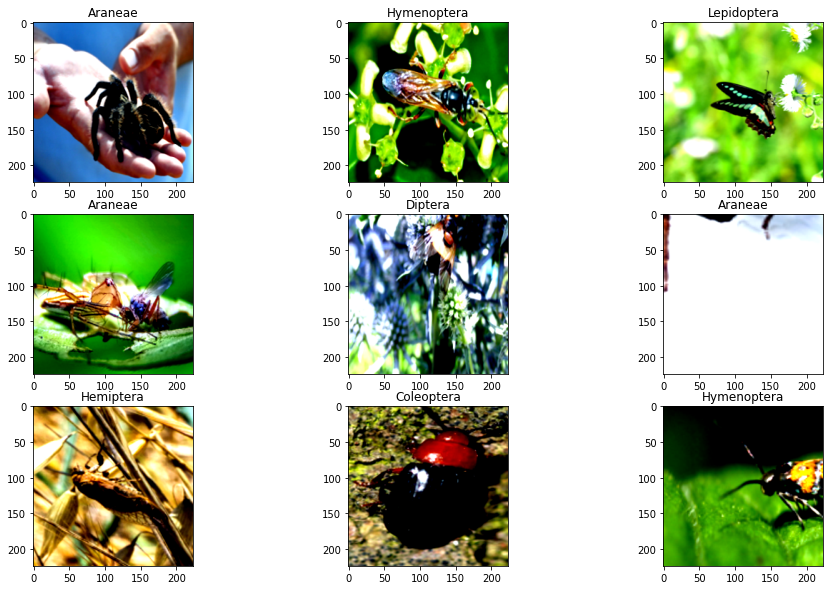

In [ ]:
def img_display(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    npimg = np.transpose(npimg, (1, 2, 0))
    return npimg

# get some random training images
dataiter = iter(dataloaders_dict["train"])
images, labels = dataiter.next()
arthopod_types = {0:"Araneae",1:"Coleoptera",2:"Diptera",
                  3:"Hemiptera",4:"Hymenoptera",5:"Lepidoptera",6:"Odonata"}
# Viewing data examples used for training
fig, axis = plt.subplots(3, 3, figsize=(16, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = images[i], labels[i]
        ax.imshow(img_display(image)) # add image
        ax.set(title = f"{arthopod_types[label.item()]}") # add label

In [ ]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [ ]:
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 10.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
for param in model_ft.parameters(): # Добавил 
    param.requires_grad = False

model_ft.fc = nn.Linear(num_ftrs, 7)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size= 7, gamma=0.1)

In [ ]:
#i = 0
#for param in model_ft.parameters():
    #if i>148 and i <=161:
        #param.requires_grad = True
    #else:
        #param.requires_grad = False
    #i+=1

In [ ]:
#i=0
#for name,param in model_ft.named_parameters():
    #if param.requires_grad == True:
        #print("\t",name)
        #i+=1
#print(i)

	 layer4.1.bn3.bias
	 layer4.2.conv1.weight
	 layer4.2.bn1.weight
	 layer4.2.bn1.bias
	 layer4.2.conv2.weight
	 layer4.2.bn2.weight
	 layer4.2.bn2.bias
	 layer4.2.conv3.weight
	 layer4.2.bn3.weight
	 layer4.2.bn3.bias
	 fc.weight
	 fc.bias
12


In [ ]:
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
num_epochs = 25

since = time.time()
val_acc_history = []
val_loss_history = []
train_acc_history =[]
train_loss_history =[]

best_model_wts = copy.deepcopy(model_ft.state_dict())
best_acc = 0.0

for epoch in range(num_epochs):
  print('Epoch {}/{}'.format(epoch, num_epochs - 1))
  print('-' * 10)
  for phase in ['train', 'val']:
    if phase == 'train':
      model_ft.train()
    else: 
      model_ft.eval()

    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in dataloaders_dict[phase]:
      inputs = inputs.to(device)
      labels = labels.to(device)

      # zero the parameter gradients
      optimizer_ft.zero_grad()

      # forward
      # track history if only in train
      with torch.set_grad_enabled(phase == 'train'):
        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

      # backward + optimize only if in training phase
        if phase == 'train':
          loss.backward()
          optimizer_ft.step()

      running_loss += loss.item() * inputs.size(0)
      running_corrects += torch.sum(preds == labels.data)

    if phase == 'train':
      exp_lr_scheduler.step()

    epoch_loss = running_loss / dataset_sizes[phase]
    epoch_acc = running_corrects.double() / dataset_sizes[phase]

    print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

    if phase == 'val' and epoch_acc > best_acc:
      best_acc = epoch_acc
      best_model_wts = copy.deepcopy(model_ft.state_dict())
    if phase == 'val':
        val_acc_history.append(epoch_acc)
        val_loss_history.append(epoch_loss)
    if phase == 'train':
        train_acc_history.append(epoch_acc)
        train_loss_history.append(epoch_loss)

  print()

time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
print('Best val Acc: {:4f}'.format(best_acc))

model_ft.load_state_dict(best_model_wts)
cmd  = "ResNet50Tuning.pt"
torch.save(model_ft,cmd)

Epoch 0/24
----------
train Loss: 1.1553 Acc: 0.5761
val Loss: 0.8667 Acc: 0.6852

Epoch 1/24
----------
train Loss: 0.9423 Acc: 0.6576
val Loss: 0.8083 Acc: 0.7158

Epoch 2/24
----------
train Loss: 0.8904 Acc: 0.6814
val Loss: 0.8847 Acc: 0.6914

Epoch 3/24
----------


KeyboardInterrupt: ignored

In [ ]:
import matplotlib.pyplot as plt

val_losses = val_loss_history
train_losses = train_loss_history

plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(val_losses,label="val")
plt.plot(train_losses,label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
val_acc = [ 0.6654, 0.7047,0.7109, 0.7161, 0.7093, 0.7187, 0.7320,0.7392,0.7402, 0.7506,0.7486, 0.7554,
 0.7545,0.7538, 0.7489, 0.7538, 0.7580, 0.7587, 0.7463,0.7470,0.7499, 0.7577,0.7610, 0.7610, 0.7515]
train_acc = [  0.5947, 0.6595, 0.6817, 0.6945, 0.7150,0.7214, 0.7325,0.7677, 0.7740, 0.7744, 0.7760,
 0.7790, 0.7869,0.7819, 0.7857,0.7859, 0.7865, 0.7916, 0.7893, 0.7860, 0.7871, 0.7942,0.7851,0.7914,
0.7829]

plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(val_acc,label="val")
plt.plot(train_acc,label="train")
plt.xlabel("iterations")
plt.ylabel("Acc")
plt.legend()
plt.show()

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [ ]:
num_images=6
new_model = model_ft
was_training = new_model.training
class_names = foldername
new_model.eval()
images_so_far = 0
fig = plt.figure()

with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders_dict['test']):
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = new_model(inputs)
      _, preds = torch.max(outputs, 1)

      for j in range(inputs.size()[0]):
        images_so_far += 1
        if images_so_far >= num_images:
          new_model.train(mode=was_training)
          break
        ax = plt.subplot(num_images//2, 2, images_so_far)
        ax.axis('off')
        ax.set_title('predicted: {}'.format(class_names[preds[j]]))
        imshow(inputs.cpu().data[j])


    new_model.train(mode=was_training)

In [ ]:
model = torch.load("./ResNet50Tuning.pt")


In [ ]:
from sklearn.metrics import classification_report
true_labels = []
predict_labels = []

with torch.no_grad():
    #number_corrects = 0
    #number_samples = 0
    for i, (img , label) in enumerate(dataloaders_dict['test']):
        img = img.to(device)
        label = label.to(device)
        true_labels.extend(label.tolist())

        pre = model(img)
        pre_label = pre.argmax(axis = 1)
        predict_labels.extend(pre_label.tolist())
        #number_corrects += (pre_label==label).sum().item()
        #number_samples += label.size(0)
    #print("Overall accuracy {}%".format((number_corrects / number_samples)*100))

print(classification_report(true_labels, predict_labels))

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics

classes =foldername
array = metrics.confusion_matrix(true_labels, predict_labels)

df_cm = pd.DataFrame(array, index = [i for i in classes],
                     columns = [i for i in classes])
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)